In [19]:
import numpy as np
from scipy import interpolate
import geatpy as ea

In [20]:
length = 435.5 / 100
rou_panel = 1859
thick_panel = 0.0015

# 电路板比热容三次样条插值
x_temp_panel = [20, 80, 120, 160, 200, 225, 240, 260, 280]
cp_panel = [1100, 1400, 1500, 1550, 1600, 1610, 1640, 1665, 1690]
f_panel_cp = interpolate.interp1d(x_temp_panel, cp_panel, kind='cubic')

# 空气各项指标随温度变化插值
x_temp_air = [20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 350]

# 动力粘度插值
eta_air = [1.81e-5, 1.86e-5, 1.91e-5, 1.96e-5, 2.01e-5, 2.06e-5, 2.11e-5, 2.15e-5,
           2.19e-5, 2.28e-5, 2.37e-5, 2.45e-5, 2.53e-5, 2.6e-5, 2.74e-5, 2.97e-5, 3.14e-5]
f_air_eta = interpolate.interp1d(x_temp_air, eta_air, kind='cubic')

# 导热系数插值
lamb_air = [2.593e-2, 2.675e-2, 2.756e-2, 2.826e-2, 2.896e-2, 2.966e-2, 3.047e-2, 3.128e-2,
            3.21e-2, 3.338e-2, 3.489e-2, 3.64e-2, 3.78e-2, 3.931e-2, 4.268e-2, 4.605e-2, 4.908e-2]
f_air_lamb = interpolate.interp1d(x_temp_air, lamb_air, kind='cubic')

# 定压比热容插值
cp_air = [1013, 1013, 1013, 1017, 1017, 1017, 1022, 1022, 1022, 1026,
          1026, 1026, 1034, 1034, 1043, 1047, 1055]
f_air_cp = interpolate.interp1d(x_temp_air, cp_air, kind='cubic')

# 流体粘度插值
u_air = [1.502e-5, 1.597e-5, 1.693e-5, 1.793e-5, 1.869e-5, 2.002e-5, 2.11e-5, 2.212e-5,
         2.315e-5, 2.539e-5, 2.775e-5, 3.006e-5, 3.248e-5, 3.485e-5, 4.065e-5, 4.829e-5, 5.548e-5]
f_air_u = interpolate.interp1d(x_temp_air, u_air, kind='cubic')


# T-air, 炉内空气温度
def T_air(v_, t_, t1_, t2_, t3_, t4_):
    air_list = []
    way = v_ * t_
    for w in way:
        if 0.0 <= w < 0.25:
            air_list.append((t1_ - 25) / 0.25 * w + 25)
        elif 0.25 <= w < 1.975:
            air_list.append(t1_)
        elif 1.975 <= w < 2.025:
            air_list.append((t2_ - t1_) / 0.05 * w - (t2_ - t1_) / 0.05 * 1.975 + t1_)
        elif 2.025 <= w < 2.33:
            air_list.append(t2_)
        elif 2.33 <= w < 2.38:
            air_list.append((t3_ - t2_) / 0.05 * w - (t3_ - t2_) / 0.05 * 2.33 + t2_)
        elif 2.38 <= w < 2.685:
            air_list.append(t3_)
        elif 2.685 <= w < 2.935:
            air_list.append((t4_ - t3_) / 0.05 * w - (t4_ - t3_) / 0.05 * 2.685 + t3_)
        elif 2.935 <= w < 3.395:
            air_list.append(t4_)
        elif 3.395 <= w < 4.105:
            air_list.append((25 - t4_) / 0.7 * w - (25 - t4_) / 0.7 * 3.395 + t4_)
        else:
            air_list.append(25)
    return np.array(air_list)


# 计算hc，对流热传导率
def calculate_hc(temp_, gama_=None):
    return 0.664 * np.power(gama_, 0.5) * \
           np.power(f_air_eta(temp_) * f_air_cp(temp_), 1 / 3) * \
           np.power(f_air_lamb(temp_), 2 / 3) / np.power(f_air_u(temp_), 0.5)


# 计算求解偏导数
def calculate_ds(hc_, k_, t_air_, temp_):
    yz = hc_ + k_ * (np.square(t_air_) + np.square(temp_)) * (t_air_ + temp_)
    return yz * (t_air_ - temp_) * (1 / (rou_panel * f_panel_cp(temp_) * thick_panel))


class CalculateEquation:
    def __init__(self):
        self.max_temp = None
        self.max_ds = None
        self.time_in_150190 = None
        self.time_high217 = None

    # 求解最大速度
    def solve_max_velocity(self, t1_, t2_, t3_, t4_, v_, gama=312):
        v_ = v_ / 6000
        second_max = int(length / v_)
        time_list = np.arange(0, second_max + 0.5, 0.5)
        temp_list = [25]
        ds_list = []
        t_air_list = T_air(v_, time_list, t1_, t2_, t3_, t4_)
        t_air_list_h2 = T_air(v_, time_list + 0.25, t1_, t2_, t3_, t4_)
        K = (5.669e-8 * 0.8 * 0.98) / (0.8 + 0.98 - 1)

        # 龙格库塔法求解
        for i in range(len(time_list) - 1):
            hc = calculate_hc(temp_list[i], gama_=gama)
            k1 = calculate_ds(hc, K, t_air_list[i], temp_list[i])
            k2 = calculate_ds(hc, K, t_air_list_h2[i], temp_list[i] + 0.25 * k1)
            k3 = calculate_ds(hc, K, t_air_list_h2[i], temp_list[i] + 0.25 * k2)
            k4 = calculate_ds(hc, K, t_air_list[i + 1], temp_list[i] + 0.5 * k3)
            ds_list.append(k1)
            temp_list.append(temp_list[i] + 0.5 / 6 * (k1 + 2 * k2 + 2 * k3 + k4))

        # 计算限制条件
        temp_list = np.array(temp_list)
        self.max_temp = np.max(temp_list)  # 最大温度
        self.max_ds = np.max(np.absolute(ds_list))  # 最大斜率

        # 计算两个时间限制
        try:            # 此处考虑到优化过程中温度过高或过低导致两个限制时间为0无法进行减法计算
            self.time_in_150190 = time_list[temp_list >= 190][0] - time_list[temp_list >= 150][0]
        except :
            self.time_in_150190 = 10
        try:
            self.time_high217 = time_list[temp_list > 217][-1] - time_list[temp_list > 217][0]
        except :
            self.time_high217 = 10

        # 近似计算积分面积
        s_list = time_list[np.argmax((temp_list >= 217).astype(np.int)): np.argmax(temp_list) + 1]
        s = 0
        for p in range(len(s_list) - 1):
            s += 0.5 * (s_list[p] + s_list[p + 1]) / 2
        return s

    def cal_cv(self):
        return [240 - self.max_temp, self.max_temp - 250, self.max_ds - 3,
                60 - self.time_in_150190, self.time_in_150190 - 120,
                40 - self.time_high217, self.time_high217 - 90]

question_model = CalculateEquation()

433966.75
443059.5
509764.875
602866.375
597302.5
598433.125
606364.375
577408.75
559932.875
557779.25
551271.875
522424.5
498034.625
502361.25
483910.375
489816.875
469695.5
463710.75
454164.875
453921.75
454145.0
438408.375
439816.375
432127.25
435129.5
428096.375
424217.75
422631.5
419231.125
413490.5
409300.75
410179.125
407665.0
407143.5
402664.0
402674.625
401066.5
403335.375
397395.875
398691.125
398196.25
395950.75
396371.5
395088.75
393417.375
393502.875
391826.375
391080.625
390916.0
388978.125
最优(最小)的目标函数值为：7582.875
最优的决策变量(t1, t2, t3, t4, v）值为：


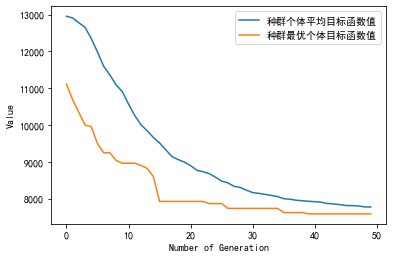

ValueError: Invalid format specifier

In [21]:
# 构造单目标带约束的多变量优化问题
class MyProblem(ea.Problem):
    def __init__(self):
        name = 'MyProblem'
        M = 1  # 初始化M（目标维数）
        max_or_min = [1]  # 初始化max_or_min（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 5  # 初始化Dim（决策变量维数）
        varTypes = [0] * Dim  # 初始化varTypes（决策变量的类型，元素为0表示对应的变量是连续的；1表示是离散的）
        low_b = [165, 185, 225, 245, 65]  # 决策变量下界
        up_b = [185, 205, 245, 265, 100]  # 决策变量上界
        low_bin = [1 for _ in range(Dim)]  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        up_bin = [1 for _ in range(Dim)]  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        ea.Problem.__init__(self, name, M, max_or_min, Dim, varTypes, low_b, up_b, low_bin, up_bin)

    def aimFunc(self, pop):  # 要优化的目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        loss = []
        cv_mat = np.zeros(shape=(1, 7))

        # 计算目标函数值, 采用可行性法则处理约束条件
        for var in Vars:
            loss.append(question_model.solve_max_velocity(var[0], var[1], var[2], var[3], var[4]))
            cv_mat = np.row_stack((cv_mat, question_model.cal_cv()))
        cv_mat = np.delete(cv_mat, 0, axis=0)
        pop.ObjV = np.reshape(np.array(loss), newshape=(-1, 1))
        pop.CV = cv_mat
        print(np.sum(loss))

problem = MyProblem()

# 种群设置
Encoding = 'RI'  # 编码方式，实数整数混合编码
N_IND = 50  # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)  # 创建区域描述器
population = ea.Population(Encoding, Field, N_IND)  # 实例化种群对象

# 设置算法参数
myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population)  # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 50  # 最大进化代数
myAlgorithm.mutOper.F = 0.5  # 差分进化中的缩放因子F
myAlgorithm.recOper.XOVR = 0.7  # 重组概率

# 调用算法进行种群进化
[population, obj_trace, var_trace] = myAlgorithm.run()

# 输出结果
best_gen = np.argmin(problem.maxormins * obj_trace[:, 1])  # 记录最优种群个体是在哪一代
best_ObjV = obj_trace[best_gen, 1]
print('最优(最小)的目标函数值为：{}'.format(best_ObjV))
print('最优的决策变量(t1, t2, t3, t4, v）值为：')
for i in range(var_trace.shape[1]):
    print('{}'.format(var_trace[best_gen, i]))
print('有效进化代数：{}'.format(obj_trace.shape[0]))
print('最优的一代是第：{} 代'.format(best_gen + 1))
print('评价次数：{}'.format(myAlgorithm.evalsNum))